In [1]:
import pymc3 as pm
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import pandas as pd
import arviz as az

## Example of Draws from a timeseries with a structural break

Imagine we're monitoring count data for traffic on a website about to run a sale. We set up a point for a break in the series where we expect a change

In [26]:
tau = np.random.randint(0, 80)
print(tau)

56


Initialising the two rate parameters to feed to our poisson distributions. We draw these parameters from the exponential distribution. The exponential distribution itself takes a parameter alpha. 

In [23]:
alpha = 1./20.
lambda_1, lambda_2 = np.random.exponential(scale=1/alpha, size=2)
print(lambda_1, lambda_2)

25.644573185011 31.967990375050764


Sampling from the Poisson Distributions

In [27]:
data = np.r_[stats.poisson.rvs(mu=lambda_1, size=tau), stats.poisson.rvs(mu=lambda_2, size = 80 - tau)]

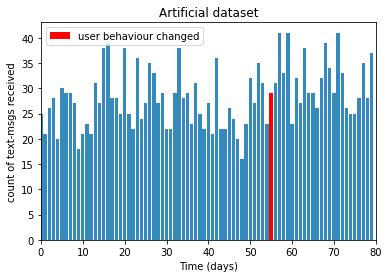

In [28]:
plt.bar(np.arange(80), data, color="#348ABD")
plt.bar(tau-1, data[tau - 1], color="r", label="user behaviour changed")
plt.xlabel("Time (days)")
plt.ylabel("count of text-msgs received")
plt.title("Artificial dataset")
plt.xlim(0, 80)
plt.legend();

## Inferring the Structure from Data

We specify the model as characterised by two poisson processes. This is the analogue to specifying the economic theory above. We're assuming some of the variables at play. We broadly characterise their relationship, dependencies and hierarchies and we build a Monte Carlo style sampler so that we may estimate the likely shape of those theoretical distributions in light of our evidence. 

In [29]:
import pymc3 as pm
import theano.tensor as tt

with pm.Model() as model:
    alpha = 1.0/data.mean()  
    lambda_1 = pm.Exponential("lambda_1", alpha)
    lambda_2 = pm.Exponential("lambda_2", alpha)
    
    tau = pm.DiscreteUniform("tau", lower=0, upper=len(data) - 1)

In [30]:
with model:
    idx = np.arange(len(data)) # Index
    lambda_ = pm.math.switch(tau > idx, lambda_1, lambda_2)

In [31]:
with model:
    observation = pm.Poisson("obs", lambda_, observed=data)

So we can estimate the best parameters that characterise the observed data by repeated sampling from the poisson distribution. 

In [32]:
with model:
    step = pm.Metropolis()
    trace = pm.sample(10000, tune=5000,step=step)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [tau]
>Metropolis: [lambda_2]
>Metropolis: [lambda_1]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 15 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.


/Users/nathanielforde/anaconda/envs/examined_algorithms/lib/python3.6/site-packages/arviz/data/io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14616b5f8>,
      dtype=object)

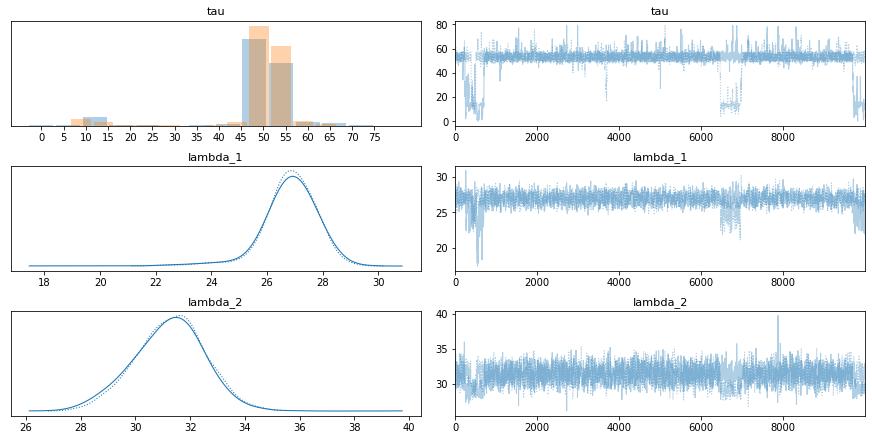

In [33]:
az.plot_trace(trace, compact=True)

The plots on the left show the overall density plots/histograms of the sampled draws from our theoretical distributions. The plots on the right show the position of each successive draw.

The process of repeated sampling from the monte-carlo simulations gives distributions with expected values very nearly exactly identical to the parameters which generated our data in the first place. Even though it's hard to see the magnitude of the difference when we plot the original timeseries, we can see here how the lambda parameter in our poisson distribution is significantly different between the two time periods. This example is taken from Cameron Davidson-Pilon's brilliant book on Bayesian inference in Python. 